<a href="https://colab.research.google.com/github/Nannanpeng/Econ_Dynamic_Programming/blob/master/Job_search_1_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade quantecon

     |████████████████████████████████| 235kB 2.8MB/s 


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from quantecon.distributions import BetaBinomial
from numba import njit, jit, jitclass, float64
from scipy.stats import norm
import quantecon as qe

## Exercise 1

In [14]:
n, a, b = 50, 200, 100                        # default parameters
q_default = BetaBinomial(n, a, b).pdf()       # default choice of q

w_min, w_max = 10, 60
w_default = np.linspace(w_min, w_max, n+1)

In [15]:
mccall_data = [
    ('c', float64),      # unemployment compensation
    ('β', float64),      # discount factor
    ('w', float64[:]),   # array of wage values, w[i] = wage at state i
    ('q', float64[:])    # array of probabilities
]

In [16]:
@jitclass(mccall_data)
class McCallModel:

    def __init__(self, c=25, β=0.99, w=w_default, q=q_default):

        self.c, self.β = c, β
        self.w, self.q = w_default, q_default

    def state_action_values(self, i, v):
        """
        The values of state-action pairs.
        """
        # Simplify names
        c, β, w, q = self.c, self.β, self.w, self.q
        # Evaluate value for each state-action pair
        # Consider action = accept or reject the current offer
        accept = w[i] / (1 - β)
        reject = c + β * np.sum(v * q)

        return np.array([accept, reject])

In [17]:
@jit(nopython=True)
def compute_reservation_wage_two(mcm, max_iter=500, tol=1e-5):
    # Simplify names
    c, β, w, q = mcm.c, mcm.β, mcm.w, mcm.q
    # == First compute h == #
    h = np.sum(w * q) / (1 - β)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        s = np.maximum(w / (1 - β), h)
        h_next = c + β * np.sum(s * q)

        error = np.abs(h_next - h)
        i += 1

        h = h_next
    # == Now compute the reservation wage == #
    return (1 - β) * h

In [18]:
@jit(nopython=True)
def Simulation(eq_w, num_sims=100_000):
  unem_len = np.empty(len(eq_w))
  status = np.arange(len(q_default))
  cdf = np.cumsum(q_default)
  for i in range(len(eq_w)):
    w_eq = eq_w[i]
    count = 0
    for _ in range(num_sims):
      w = 0
      while w < w_eq:
        idx = qe.random.draw(cdf)
        w = w_default[idx]
        count += 1
    unem_len[i] = count/num_sims
  return unem_len

In [19]:
c_vals = np.linspace(10, 40, 25)
eq_w = np.empty(len(c_vals))
for i in range(len(c_vals)):
  mcm = McCallModel(c=c_vals[i])
  eq_w[i] = compute_reservation_wage_two(mcm)

In [20]:
%%time
unem_len = Simulation(eq_w)

CPU times: user 2 s, sys: 1.69 ms, total: 2 s
Wall time: 2 s


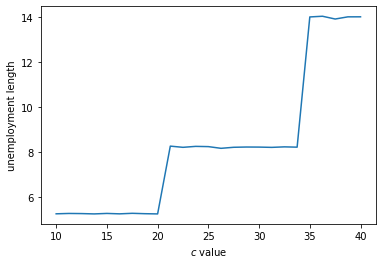

In [21]:
plt.plot(c_vals, unem_len)
plt.xlabel('$c$ value')
plt.ylabel('unemployment length');

## Exercise 2

In [22]:
random_s = norm.rvs(size=30000)
@jit(nopython=True)
def compute_reservation_wage_three(mcm, max_iter=50000, tol=1e-5, n_sims=2000):
    # Simplify names
    c, β, sigma, mu = mcm.c, mcm.β, 0.5, 2.5
    # == First compute h == #
    h = np.exp(mu) / (1 - β)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:
        right = np.exp(mu + sigma*random_s) / (1 - β)
        s = np.maximum(right, h)
        h_next = c + β * s.mean()

        error = np.abs(h_next - h)
        i += 1

        h = h_next
    # == Now compute the reservation wage == #
    print(i, h)
    return (1 - β) * h

In [23]:
%%time

mcm = McCallModel()
compute_reservation_wage_three(mcm)

572 3578.622555531908
CPU times: user 830 ms, sys: 5.84 ms, total: 836 ms
Wall time: 847 ms
